In [1]:
#Loading the standard set of packages used for this analysis
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})


Warning message:
“package ‘data.table’ was built under R version 4.3.3”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.3.3”
Warning message:
“package ‘Biostrings’ was built under R version 4.3.3”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.3”


# Genomic PAX5 Analysis

In [66]:
source("DNA_filtering_Functions.R")

In [67]:
AllelesPAX5_A <- read_delim("PAX5/allCells_allele_A.txt")
#Fix naming of columns
AllelesPAX5_A <- AllelesPAX5_A %>% rename(bc = "DNA_cell") %>% separate(smp, into = c("Plate", "sample"))
AllelesPAX5_A <- inner_join(read_csv("DNABarcodes.csv"), AllelesPAX5_A) # Merge with DNA barcodes

Rows: 439516 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Aligned_Sequence, Reference_Sequence, Reference_Name, Read_Status, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, DNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(DNA_cell)`


In [68]:
#Create a plate_well ID for easy cell identification by combining the barcode DNA with the well_ID
AllelesPAX5_A <- AllelesPAX5_A %>% mutate(plate_well = paste0(sample, DNA_cell))
#Group by this ID to create a grouped table. 
AllelesPAX5_A<- AllelesPAX5_A%>% group_by(plate_well)

#Add the total # of reads per cell in a a new columbn for filtering. Future iterations of this analysis will simply multiply % of total * the number. 
AllelesPAX5_A<- AllelesPAX5_A %>% summarize("TotalReads"=sum(`#Reads`)) %>% inner_join(AllelesPAX5_A)

Joining with `by = join_by(plate_well)`


In [69]:
#Fix name
AllelesPAX5_A <- dplyr::rename(AllelesPAX5_A,Barcode_DNA = sample)
#Take top 10 alleles for visualiztion
AllelesPAX5_A <- AllelesPAX5_A %>% group_by(plate_well) %>% dplyr::slice_head(n=10)

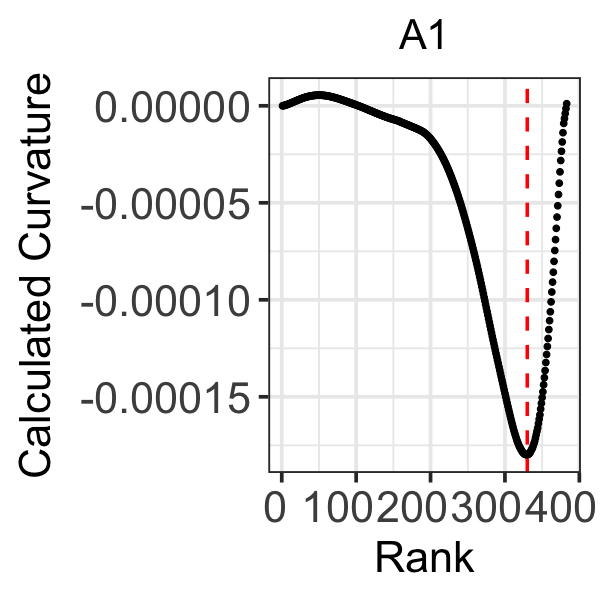

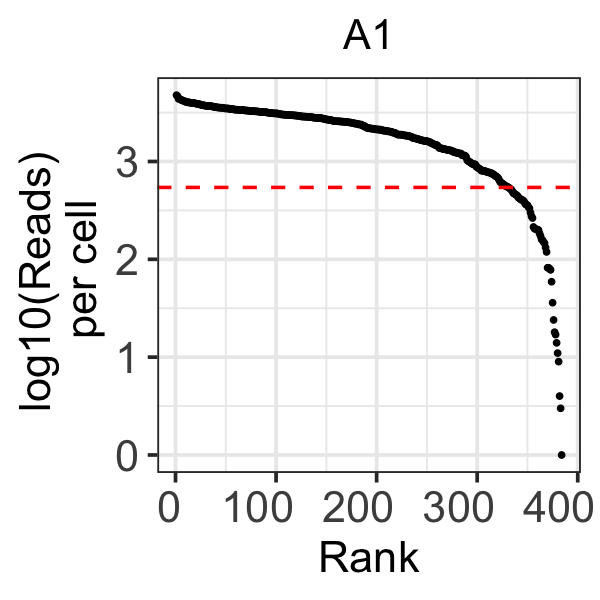

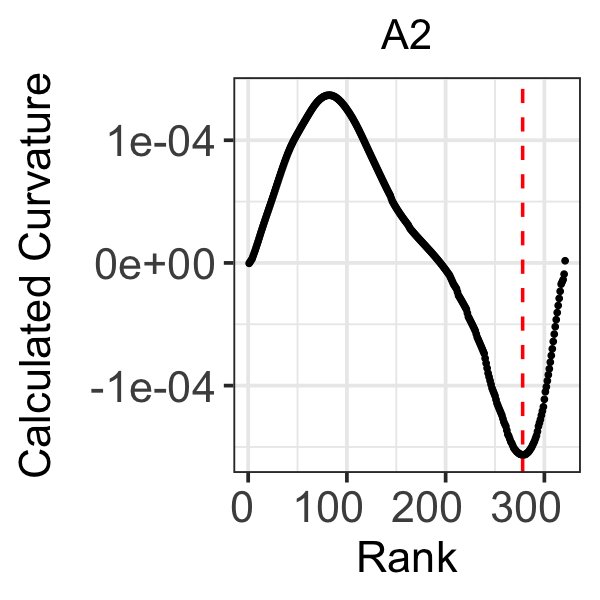

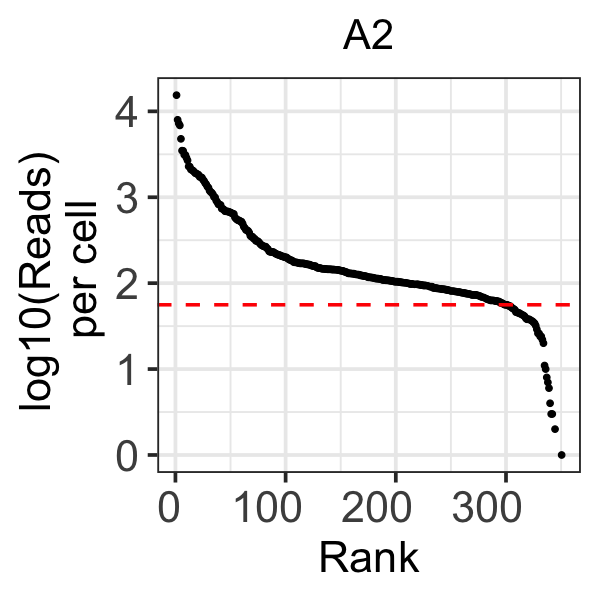

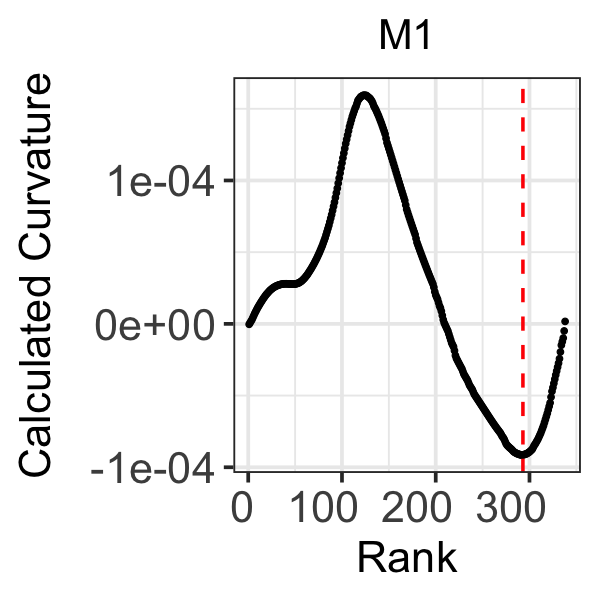

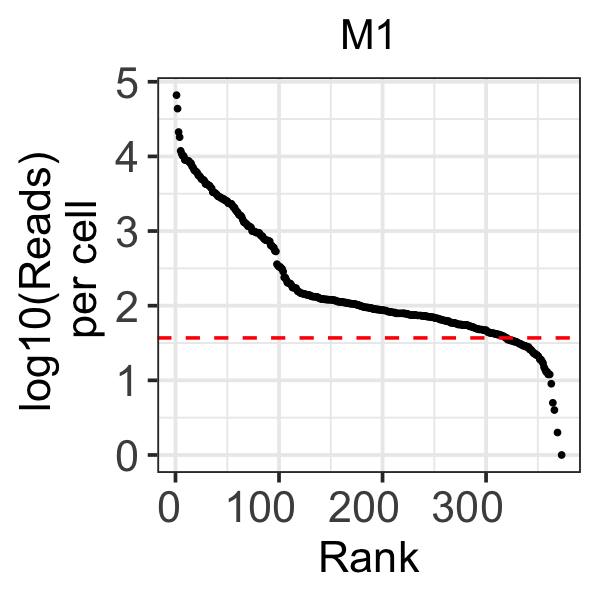

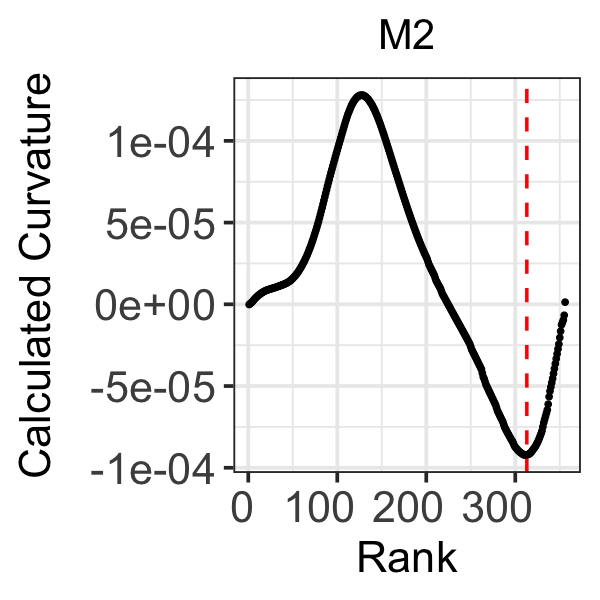

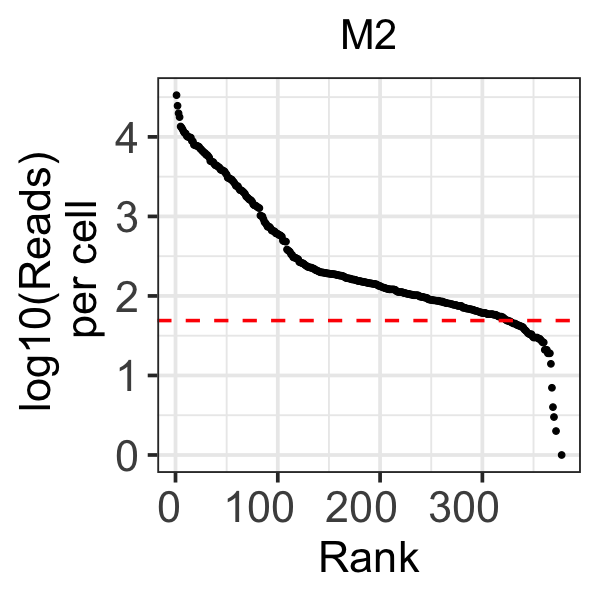

In [70]:
fig.size(5,5)
Filter_Alleles_PAX5A <- Filtering_Cells_Read(AllelesPAX5_A)

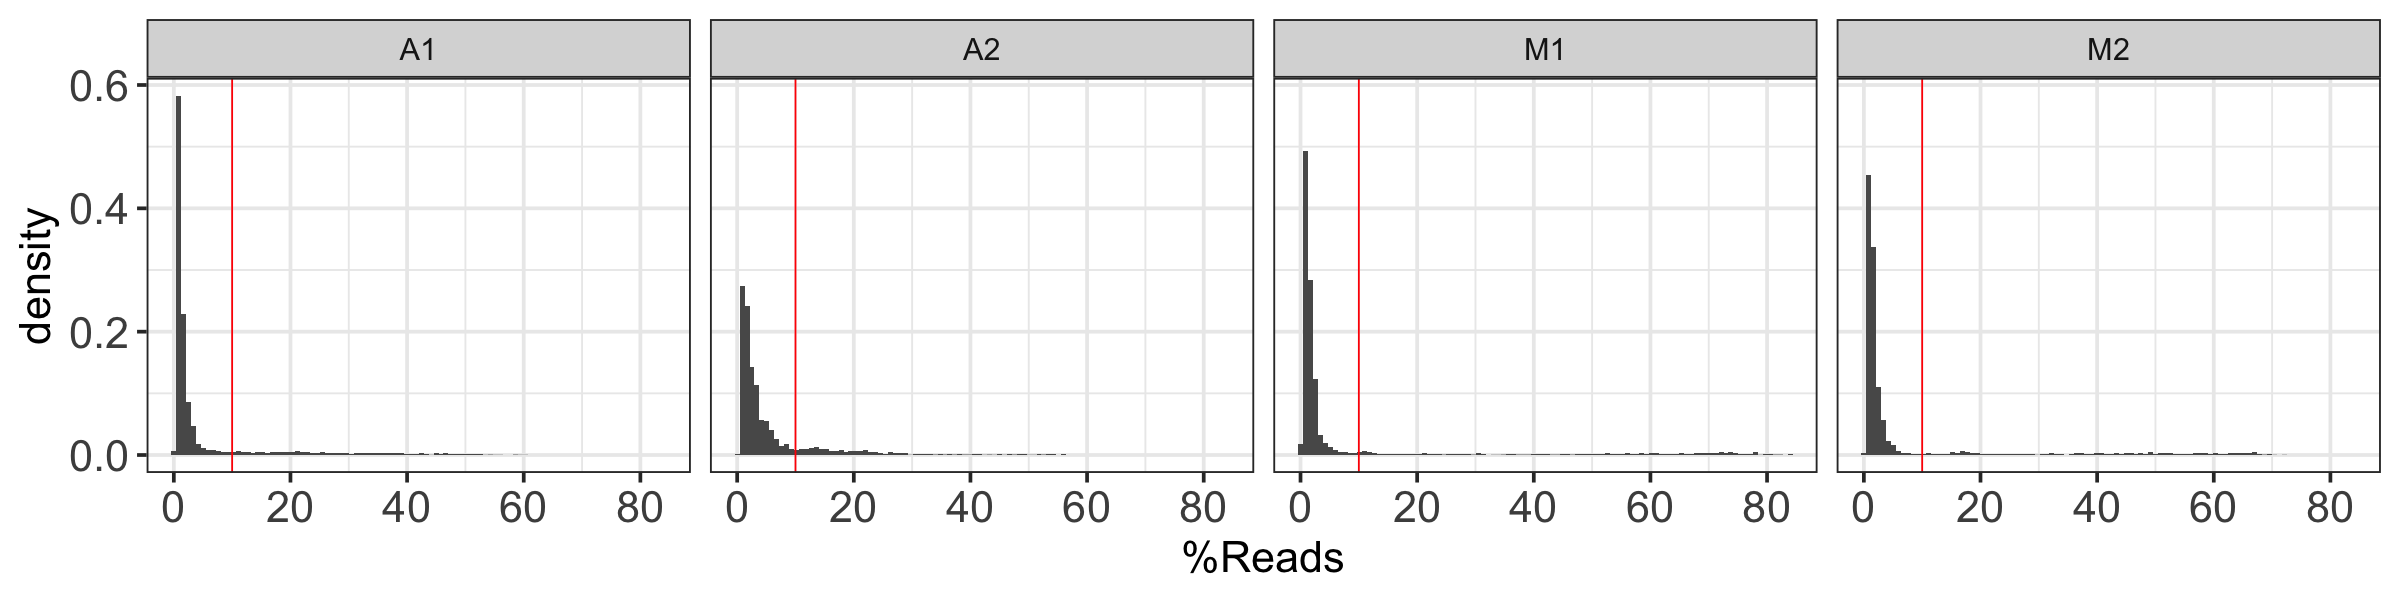

In [71]:
fig.size(5,20)
Filter_Alleles_PAX5A  %>% ggplot(aes(`%Reads`)) + 
geom_histogram(aes(y = ..density..),bins = 100) + theme_gy() + geom_vline(xintercept = 10, color = "red") + 
facet_grid(~Barcode_DNA)

In [72]:
Filter_Alleles_PAX5A <- Filtering_Alleles(ungroup(Filter_Alleles_PAX5A), 10)

In [73]:
Filter_Alleles_PAX5A <- mutate(Filter_Alleles_PAX5A, Reference = "CAGCGGTGCTTCTCCTATGTGACTGGTTCTAACTACCCTTTCCCTTTCCTTTTGTTTCTGATCTGTTTCAGGACATGGAGGAGTGAATCAGCTTGGGGGGGTTTTTGTGAATGGACGGCCACTCCCGGATGTAGTCCGCCAGAGGATA")

In [74]:
#Trim length for visualization and plotting
Filter_Alleles_PAX5A<- 
    mutate(Filter_Alleles_PAX5A, 
           "Aligned_Sequence" = str_trunc(Aligned_Sequence, 75, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 75, "left", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 40, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 40, "right", ellipsis = ""))

In [75]:
Filter_Alleles_PAX5A <- Filter_Alleles_PAX5A %>% add_count(Aligned_Sequence) %>% filter(n > 10)

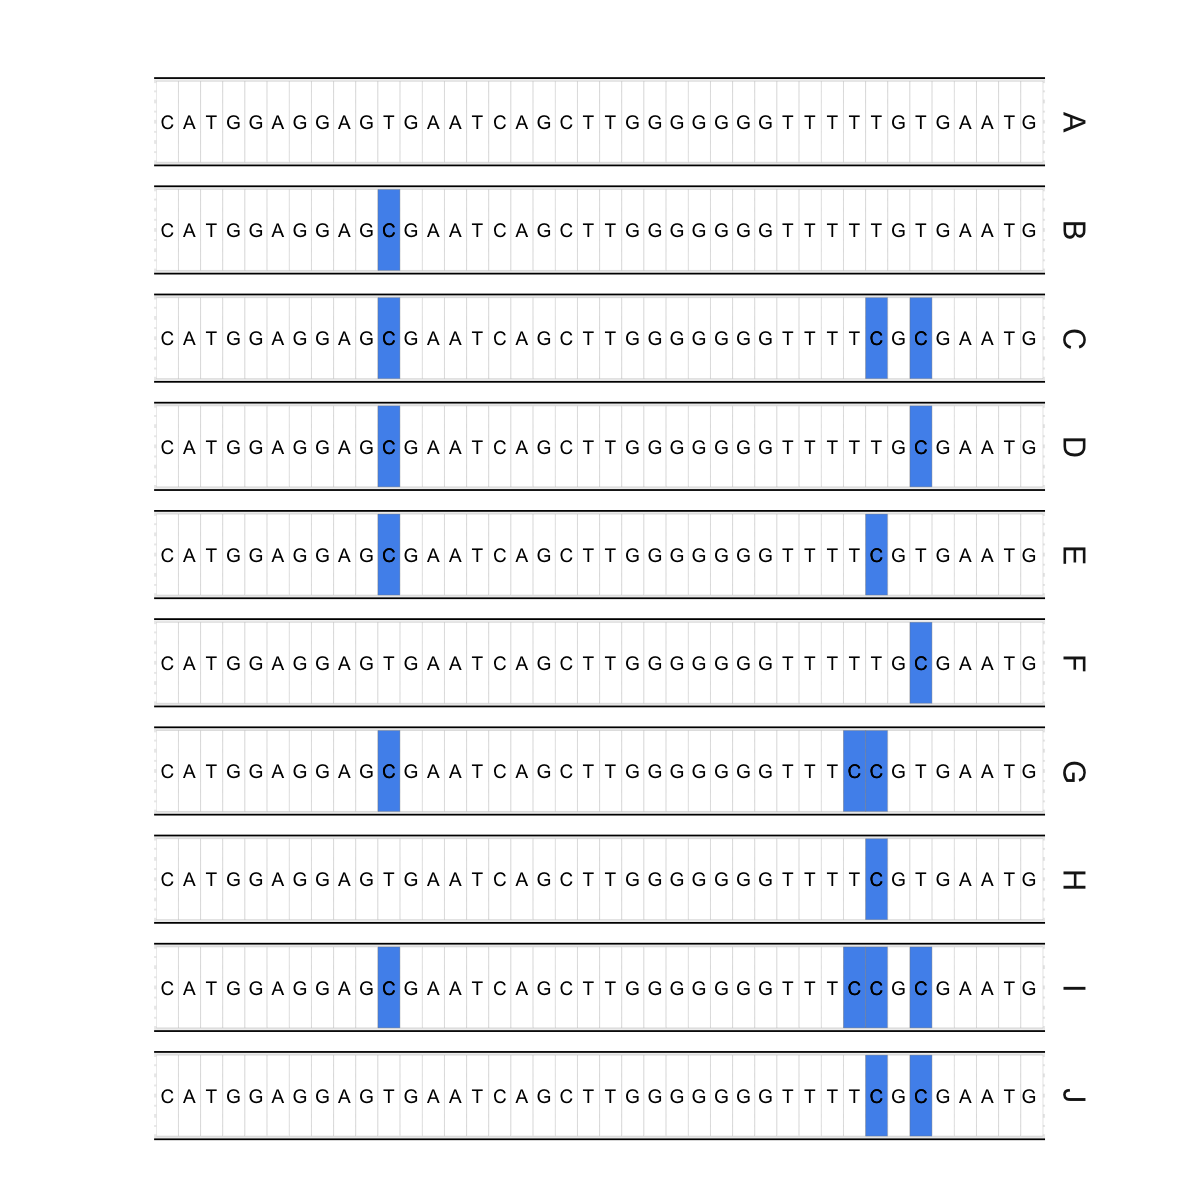

In [76]:
Filter_Alleles_PAX5A %>% Plotting_Alleles

In [77]:
Filter_Alleles_PAX5A_gen <- Filter_Alleles_PAX5A %>% Genotyping_Cells %>% add_count(AllelicGenotype) %>% filter(n>5) 

In [83]:
Filter_Alleles_PAX5A_gen %>% inner_join(Filter_Alleles_PAX5A, by = "plate_well") %>% select(AllelicGenotype, Barcode_DNA) %>% table

               Barcode_DNA
AllelicGenotype  A1  A2  M1  M2
             A  117 175 253 259
             AB  47  28  37  34
             AC   0 102  17  31
             AD   4   8   6  10
             AE   2   2  10   4
             AF   8   0  14   8
             AG   4   4   2   2
             AH   2   6   4   4
             AJ  14   6   8  38
             B   31   9   6   0
             BC  19   0   0   0
             C   41  12   4   0
             CD  14   0   0   0
             CI  12   0   0   0
             D   13   4   2   0
             E    7   2   2   0
             G    6   1   0   0
             I    4   3   0   0
             J    3   3   2   0

In [306]:
write_csv(Filter_Alleles_PAX5A_gen, "PAX5A_gen.csv")

# PAX5 Region B

In [84]:
AllelesPAX5_B <- read_delim("PAX5/allCells_allele_B.txt")
#Fix naming of columns
AllelesPAX5_B <- AllelesPAX5_B %>% rename(bc = "DNA_cell") %>% separate(smp, into = c("Plate", "sample"))
AllelesPAX5_B <- inner_join(read_csv("DNABarcodes.csv"), AllelesPAX5_B) # Merge with DNA barcodes

Rows: 378459 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Aligned_Sequence, Reference_Sequence, Reference_Name, Read_Status, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, DNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(DNA_cell)`


In [85]:
#Create a plate_well ID for easy cell identification by combining the barcode DNA with the well_ID
AllelesPAX5_B <- AllelesPAX5_B %>% mutate(plate_well = paste0(sample, DNA_cell))%>% group_by(plate_well)

#Add the total # of reads per cell in a a new columbn for filtering. Future iterations of this analysis will simply multiply % of total * the number. 
AllelesPAX5_B<- AllelesPAX5_B %>% summarize("TotalReads"=sum(`#Reads`)) %>% inner_join(AllelesPAX5_B)

Joining with `by = join_by(plate_well)`


In [86]:
#Fix name
AllelesPAX5_B <- rename(AllelesPAX5_B, sample = "Barcode_DNA")
#Take top 10 alleles for visualiztion
AllelesPAX5_B <- AllelesPAX5_B %>% group_by(plate_well) %>% dplyr::slice_head(n=10)

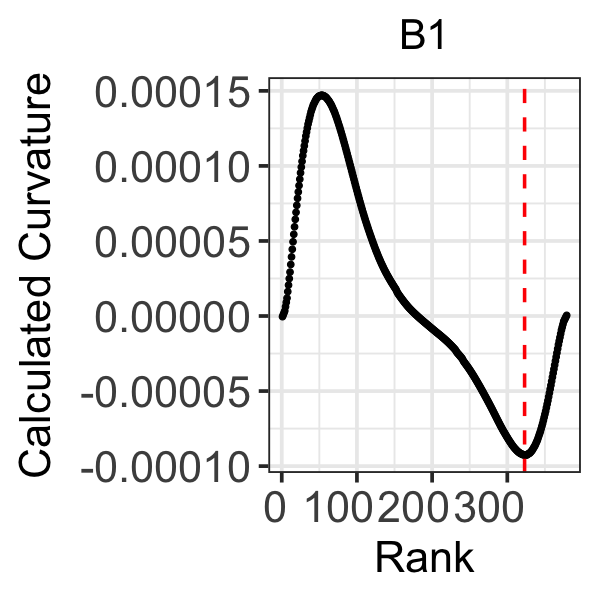

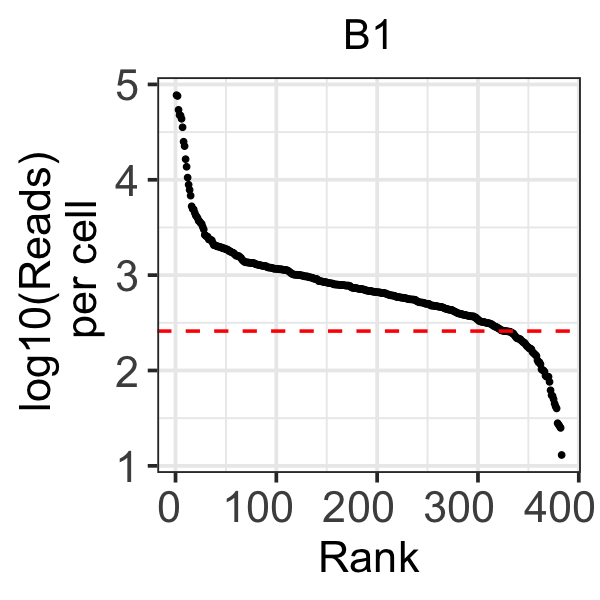

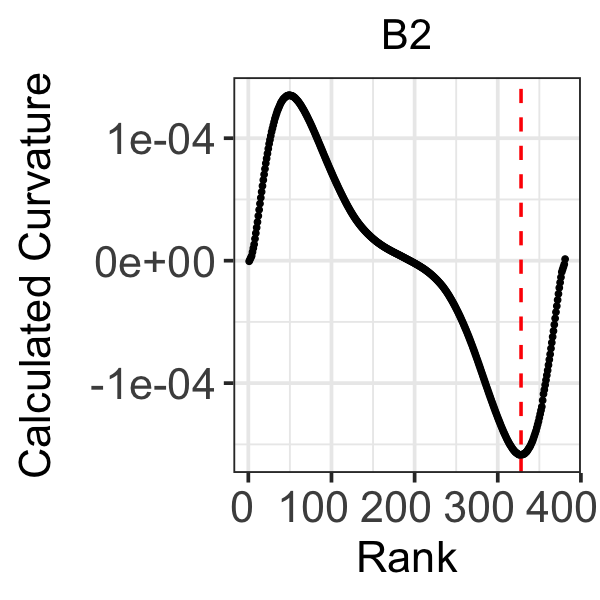

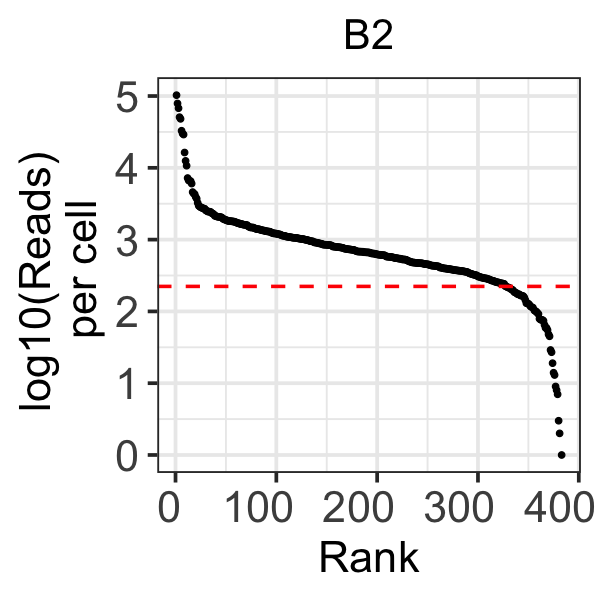

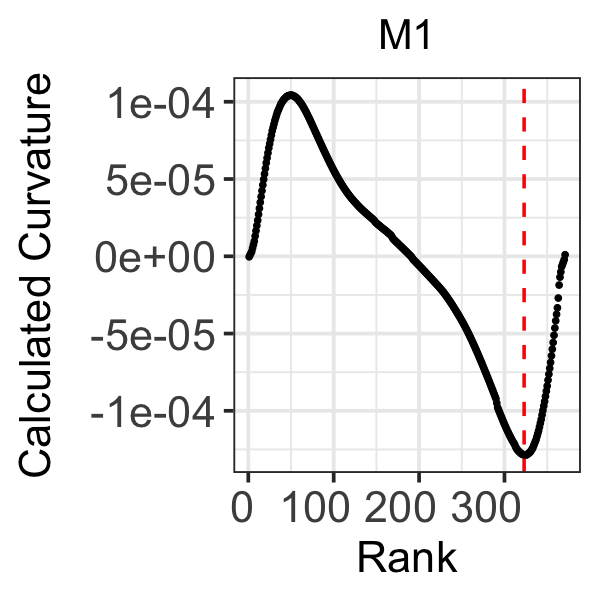

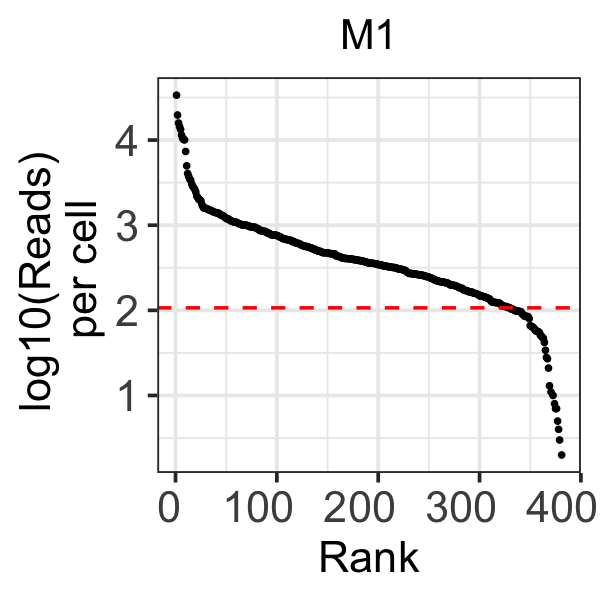

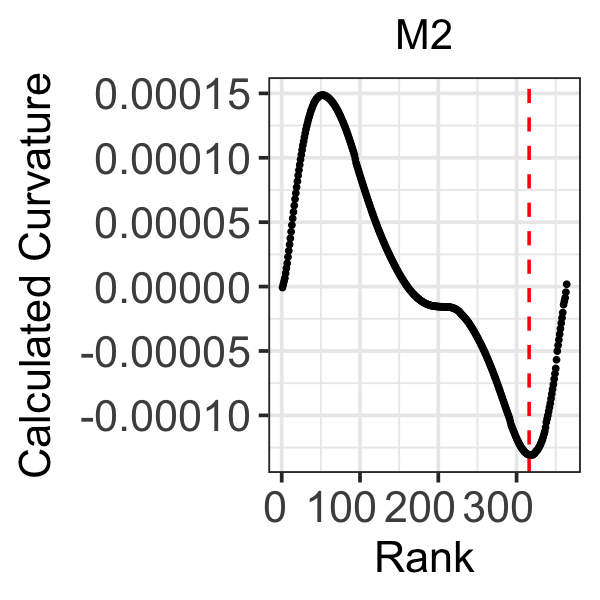

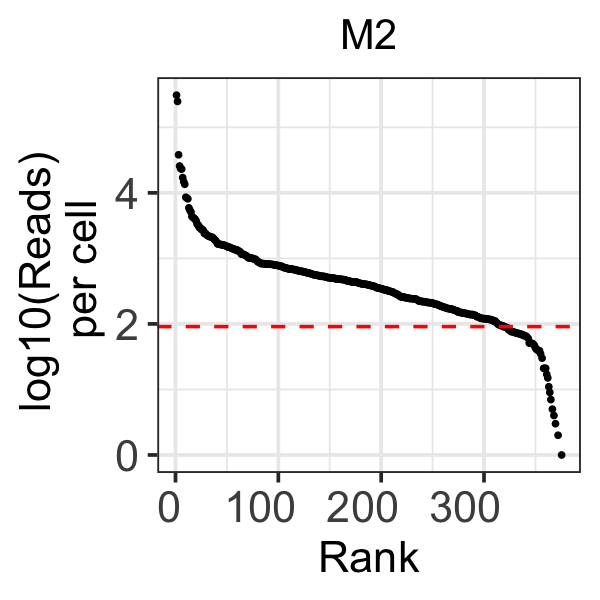

In [87]:
fig.size(5,5)
Filter_Alleles_PAX5B <- Filtering_Cells_Read(AllelesPAX5_B)

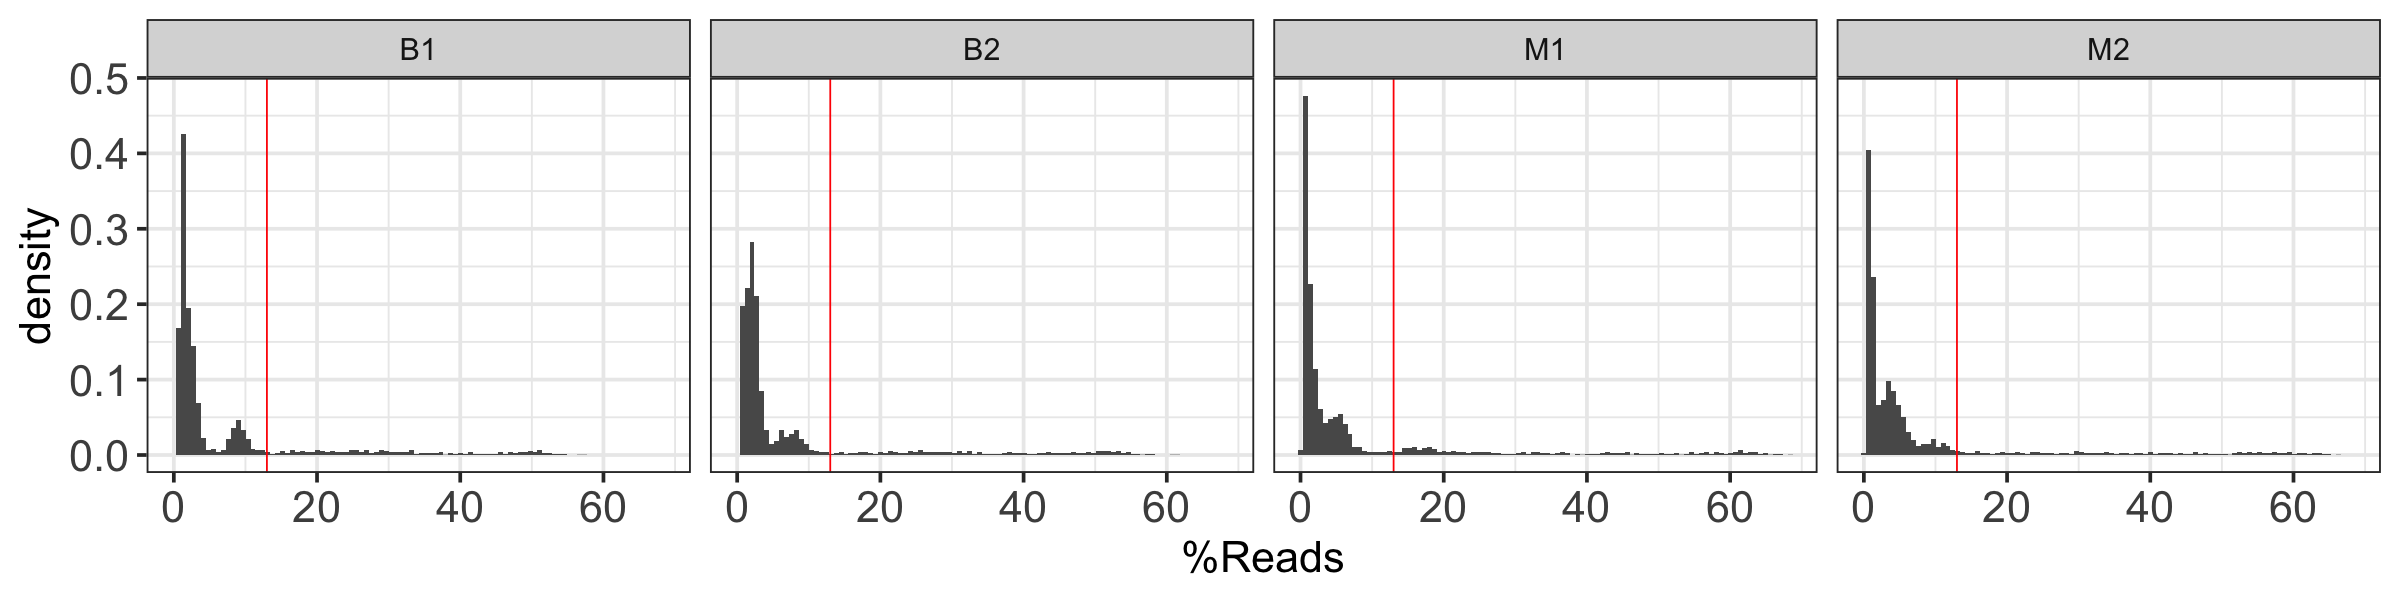

In [88]:
fig.size(5,20)
Filter_Alleles_PAX5B  %>% ggplot(aes(`%Reads`)) + 
geom_histogram(aes(y = ..density..),bins = 100) + theme_gy() + geom_vline(xintercept = 13, color = "red") + 
facet_grid(~Barcode_DNA)

In [89]:
Filter_Alleles_PAX5B <- Filtering_Alleles(ungroup(Filter_Alleles_PAX5B), 15)

In [90]:
Filter_Alleles_PAX5B <- mutate(Filter_Alleles_PAX5B, Reference = "GTTTGCCTGGGAGATCAGGGACCGGCTGCTGGCAGAGCGGGTGTGTGACAATGACACCGTGCCTAGCGTCAGTTCCATCAACAGGTGAGGGGCTCGTGCCTGTGGGGGTTGGGGATTTGGAGGGATGGCAGGGCATCCTGGAGGCTCT")

In [91]:
#Trim length for visualization and plotting
Filter_Alleles_PAX5B<- 
    mutate(Filter_Alleles_PAX5B, 
           "Aligned_Sequence" = str_trunc(Aligned_Sequence, 84, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 84, "right", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 30, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 30, "left", ellipsis = ""))

In [92]:
Filter_Alleles_PAX5B <- Filter_Alleles_PAX5B %>% add_count(Aligned_Sequence) %>% filter(n > 5)

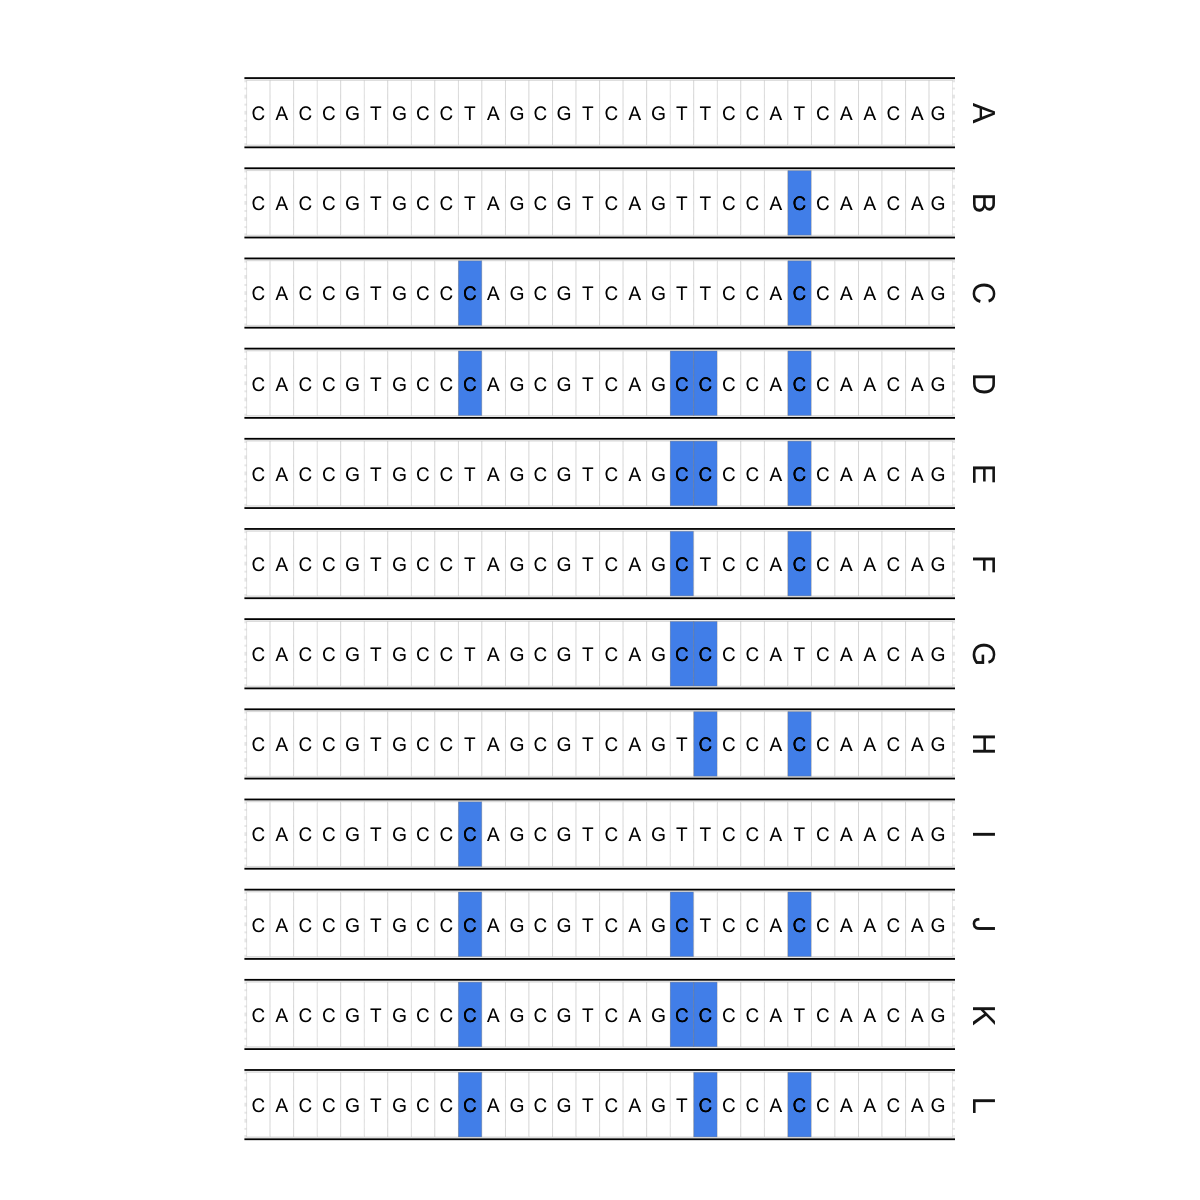

In [93]:
Filter_Alleles_PAX5B %>% Plotting_Alleles


In [94]:
Filter_Alleles_PAX5B_gen <- Filter_Alleles_PAX5B %>% Genotyping_Cells %>% add_count(AllelicGenotype) %>% filter(n>5) 

In [320]:
write_csv(Filter_Alleles_PAX5B_gen, "PAX5B_gen.csv")